# Ukraine War Sentiment Analysis Project

### Required packages

In [15]:
from pathlib import Path
import numpy as np
import pandas as pd

import string
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

### Defining paths and directory creation

In [4]:
# define Path object for data directory
data_dir = Path('./data')

# print data files
for data_file in data_dir.glob('*'):
    print(data_file)
    
# create directory for plots
plots_dir = Path('./plots').mkdir(exist_ok=True)

data/train.json
data/test.json


### Loading in datasets

In [5]:
train = pd.read_json(data_dir / 'train.json')
test = pd.read_json(data_dir / 'test.json')

print(train.shape)
train.head(5)

(8263, 3)


,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative


### Data preprocessing

In [7]:
# to lower
train.text = train.text.apply(lambda x: x.lower())
test.text = test.text.apply(lambda x: x.lower())

# remove punctuation
train.text = train.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
test.text = test.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

train.text[0]

'досудебное расследование по факту покупки енпф пакета облигаций тоо бузгул аурум было начато по инициативе национального банка рк сообщил директор департамента защиты прав потребителей и финансовых услуг нацбанка казахстана александр терентьев\nоснованием для досудебного расследования стало обращение национального банка письмо от 25 ноября 2016 года было обращение национального банка в правоохранительные органы нам эта сделка показалась сомнительной недостаточно корректной поэтому нацбанк 25 ноября 2016 года обратился в правоохранительные органы это то что я могу озвучить на сегодня идёт следствие проводится проверка – сказал терентьев\n28 декабря в нацбанке заявили что не знают что стало основанием для проверки енпф\n23 декабря факт проведения проверки в ао единый накопительный пенсионный фонд подтвердился прессслужба национального банка сообщила что проверку проводят по операциям совершённым ао енпф в отношении инвестирования собственных активов\nтакже в финрегуляторе сообщали что п

### Visualising lengths of documents

Average document: 515 words
Longest document: 49039 words
1 std above the mean: 1707 words


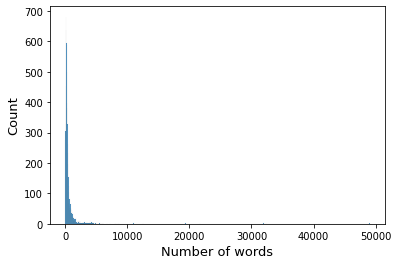

In [10]:
# get the number of words in each sample
doc_len = train.text.apply(lambda x: len(x.split(' '))).to_numpy()
max_words = int(doc_len.mean() + doc_len.std())

# plot histogram
sns.histplot(doc_len)
plt.xlabel("Number of words", fontsize=13)
plt.ylabel("Count", fontsize=13)

print(f"Average document: {int(doc_len.mean())} words")
print(f"Longest document: {doc_len.max()} words")
print(f"1 std above the mean: {max_words} words")

Number of training examples: 7871
Number of test examples: 1943


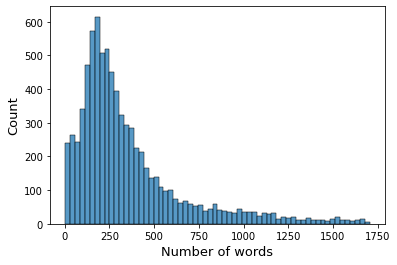

In [11]:
# removing any documents with len(words) greater than 1 std dev from mean
train = train[train.text.apply(lambda x: len(x.split(' '))) < max_words]
test = test[test.text.apply(lambda x: len(x.split(' '))) < max_words]

sns.histplot(train.text.apply(lambda x: len(x.split(' '))))
plt.xlabel("Number of words", fontsize=13)
plt.ylabel("Count", fontsize=13)

print(f"Number of training examples: {train.shape[0]}")
print(f"Number of test examples: {test.shape[0]}")

In [8]:
### under-sampling for balanced data set

# print(train.sentiment.value_counts())

# positive_train = train[train.sentiment == 'positive'].sample(1373)
# neutral_train = train[train.sentiment == 'neutral'].sample(1373)
# negative_train = train[train.sentiment == 'negative'].sample(1373)

# train = pd.DataFrame(np.vstack([positive_train, neutral_train, negative_train]))
# train.columns = ['text', 'id', 'sentiment']

# print(train.sentiment.value_counts())

In [12]:
X_train = train.text
y_train = train.sentiment

X_test = test.text

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nX_test shape: {X_test.shape}")

X_train shape: (7871,)
y_train shape: (7871,)

X_test shape: (1943,)


### Training a base model

In [14]:
# number of words to consider in the vocabulary
vocab_size = 1000

# preprocessing X_train
docs = X_train.to_numpy()
encoded_docs = [one_hot(d, vocab_size) for d in docs]
padded_docs = pad_sequences(encoded_docs, maxlen=max_words, padding='post')

# preprocessing y_train
encoder = LabelEncoder()
labels = encoder.fit_transform(y_train)

print(f"X_train shape: {padded_docs.shape}")
print(f"y_train shape: {labels.shape}")

X_train shape: (7871, 1707)
y_train shape: (7871,)


In [17]:
opt = keras.optimizers.SGD(learning_rate=0.0001)

rnn_out = 8

model = Sequential()
model.add(layers.Embedding(vocab_size, 8, input_length=max_words))
model.add(layers.LSTM(rnn_out))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1707, 8)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 8,571
Trainable params: 8,571
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(padded_docs, labels, epochs=10, verbose=1)

Epoch 1/10
212/246 [========================>.....] - ETA: 17s - loss: 1.0941 - accuracy: 0.4829

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Training with pretrained embeddings

In [ ]:
path_to_model_file = "model/model.txt"

embeddings_index = {}
with open(path_to_model_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word.split('_')[0]] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
t = Tokenizer()

t.fit_on_texts(X_train)

vocab_size = len(t.word_index) + 1

encoded_docs = t.texts_to_sequences(X_train)

max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

In [ ]:
padded_docs

In [ ]:
from tensorflow import keras
opt = keras.optimizers.SGD(learning_rate=0.0001)

In [ ]:
lstm_out = 16

model = Sequential()
model.add(layers.Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(layers.LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

In [ ]:

encoder = LabelEncoder()
labels = encoder.fit_transform(train.sentiment)

In [ ]:
history = model.fit(padded_docs, labels, epochs=20, validation_split=0.2, verbose=1)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()